## Import lib

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os, string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F
import gensim.models.keyedvectors as word2vec
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import torch.optim as optim
from tqdm import tqdm 

## Read data

In [3]:
# Function to read data
def read_data(pathdata):
    traindata = []
    sents = open(pathdata, 'r', encoding='utf-8').readlines()
    for sent in sents:
        traindata.append(sent.split())
    return traindata

train_data = read_data("D:/Big_Data/NLP_HW-2/datatrain.txt")
print(train_data[:10])  # Print first 10 lines of training data as example

[['danh_sách', 'tác_phẩm', 'doraemon'], ['doraemon', 'nguyên_tác', 'là', 'xê', 'ri', 'anime', 'và', 'manga', 'được', 'sáng_tác', 'bởi', 'fujiko_f'], ['bắt_đầu_từ', 'những', 'chương', 'truyện', 'nhỏ', 'đăng', 'trên', 'tạp_chí', 'tháng', 'corocoro', 'comic', 'sau', 'đó', 'shogakukan', 'tập_hợp', 'lại', 'phát_hành', 'theo', 'cuốn', 'từ', 'tập', '1', 'đến', 'tập', '45'], ['sau', 'đó', 'chuyển_thể', 'thành', 'anime', 'theo', 'ba', 'giai_đoạn', 'phim', 'hoạt_hình', '1973', '1979', '2005', 'và', '2005'], ['năm', '2014', 'viz_media', 'mua', 'bản_quyền', 'mỹ_hóa', 'các', 'yếu_tố', 'trong', 'phim', 'như', 'tên', 'nhân_vật', 'địa_điểm'], ['và', 'phát_sóng', 'trên', 'disney', 'xd', 'kể', 'từ', '7', 'tháng', '7'], ['xê', 'ri', 'cũng', 'được', 'chuyển_thể', 'thành', 'nhiều', 'tác_phẩm', 'khác', 'nhau', 'như', 'doraemon_plus', 'truyện_ngắn', 'truyện_dài', 'phim', 'điện_ảnh', 'trò_chơi', 'điện_tử', 'nhạc_kịch', 'băng_đĩa'], ['dưới', 'đây', 'là', 'danh_sách', 'các', 'tác_phẩm', 'về', 'doraemon', 'được'

## One-hot encoding

In [5]:
train_data_str = [' '.join(sent) for sent in train_data[:4]]

# CountVectorizer for One Hot Encoding
vectorizer = CountVectorizer(binary=True)
one_hot_encoded = vectorizer.fit_transform(train_data_str)
one_hot_encoded_array = one_hot_encoded.toarray()

for i in range(0, 3):
    print("Source sentence: ", train_data_str[i])
    print("One Hot Encoding: ", one_hot_encoded_array[i])
    print("\n")

Source sentence:  danh_sách tác_phẩm doraemon
One Hot Encoding:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0]


Source sentence:  doraemon nguyên_tác là xê ri anime và manga được sáng_tác bởi fujiko_f
One Hot Encoding:  [0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0]


Source sentence:  bắt_đầu_từ những chương truyện nhỏ đăng trên tạp_chí tháng corocoro comic sau đó shogakukan tập_hợp lại phát_hành theo cuốn từ tập 1 đến tập 45
One Hot Encoding:  [0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1
 1 1 1 0 0 1 1 0 1]




## TF-IDF encoding

In [7]:
# TfidfVectorizer for TF-IDF Encoding
tfidf_vectorizer = TfidfVectorizer()
tfidf_encoded = tfidf_vectorizer.fit_transform(train_data_str)
tfidf_encoded_array = tfidf_encoded.toarray()

for i in range(0, 3):
    print("Source sentence: ", train_data_str[i])
    print("TF-IDF Encoding: ", tfidf_encoded_array[i])
    print("\n")


Source sentence:  danh_sách tác_phẩm doraemon
TF-IDF Encoding:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.61761437 0.48693426 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.61761437
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


Source sentence:  doraemon nguyên_tác là xê ri anime và manga được sáng_tác bởi fujiko_f
TF-IDF Encoding:  [0.         0.         0.         0.         0.23918972 0.
 0.         0.30338183 0.         0.         0.         0.
 0.         0.         0.23918972 0.30338183 0.         0.
 0.30338183 0.         0.30338183 0.30338183 0.         0.
 0.         0.         0.30338183 0.         0.         0.30338183
 0.         0.         0.         0.         0.         0

## Windows based cooccurence matrix

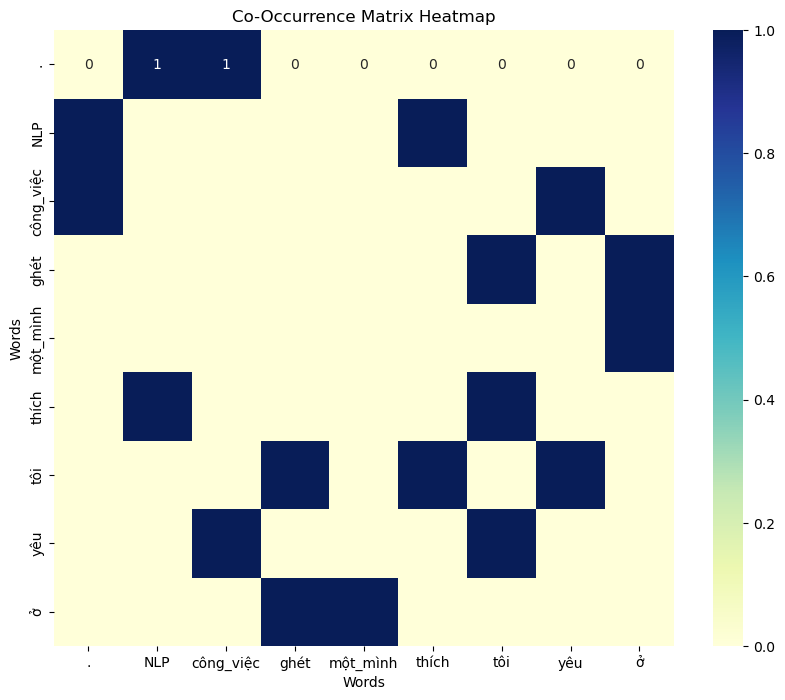

In [8]:
# Co-occurrence matrix
corpus = ["tôi yêu công_việc .",
          "tôi thích NLP .",
          "tôi ghét ở một_mình"]

words = []
for sentence in corpus:
    words.extend(sentence.split())

words = list(set(words))
words.sort()

X = np.zeros((len(words), len(words)))

for sentence in corpus:
    tokens = sentence.split()
    for i, token in enumerate(tokens):
        if i == 0:
            X[words.index(token), words.index(tokens[i + 1])] += 1
        elif i == len(tokens) - 1:
            X[words.index(token), words.index(tokens[i - 1])] += 1
        else:
            X[words.index(token), words.index(tokens[i + 1])] += 1
            X[words.index(token), words.index(tokens[i - 1])] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(X, xticklabels=words, yticklabels=words, cmap="YlGnBu", annot=True, fmt="g")

plt.title("Co-Occurrence Matrix Heatmap")
plt.xlabel("Words")
plt.ylabel("Words")
plt.show()

## Singular Decomposition Value

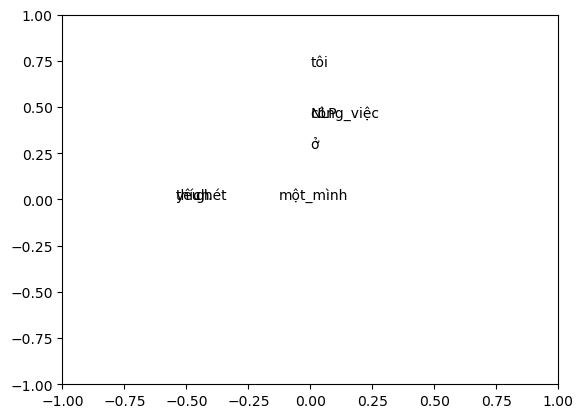

In [9]:
# SVD
la = np.linalg
U, s, Vh = la.svd(X, full_matrices=False)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

for i in range(len(words)):
    plt.text(U[i, 0], U[i, 1], words[i])

plt.show()

In [10]:
train_data = [' '.join(sent) for sent in train_data]

In [51]:
print(train_data[:5])

['danh_sách tác_phẩm doraemon', 'doraemon nguyên_tác là xê ri anime và manga được sáng_tác bởi fujiko_f', 'bắt_đầu_từ những chương truyện nhỏ đăng trên tạp_chí tháng corocoro comic sau đó shogakukan tập_hợp lại phát_hành theo cuốn từ tập 1 đến tập 45', 'sau đó chuyển_thể thành anime theo ba giai_đoạn phim hoạt_hình 1973 1979 2005 và 2005', 'năm 2014 viz_media mua bản_quyền mỹ_hóa các yếu_tố trong phim như tên nhân_vật địa_điểm']


In [52]:
train_data = [sentence.split() for sentence in train_data]

In [53]:
print(train_data[:5])

[['danh_sách', 'tác_phẩm', 'doraemon'], ['doraemon', 'nguyên_tác', 'là', 'xê', 'ri', 'anime', 'và', 'manga', 'được', 'sáng_tác', 'bởi', 'fujiko_f'], ['bắt_đầu_từ', 'những', 'chương', 'truyện', 'nhỏ', 'đăng', 'trên', 'tạp_chí', 'tháng', 'corocoro', 'comic', 'sau', 'đó', 'shogakukan', 'tập_hợp', 'lại', 'phát_hành', 'theo', 'cuốn', 'từ', 'tập', '1', 'đến', 'tập', '45'], ['sau', 'đó', 'chuyển_thể', 'thành', 'anime', 'theo', 'ba', 'giai_đoạn', 'phim', 'hoạt_hình', '1973', '1979', '2005', 'và', '2005'], ['năm', '2014', 'viz_media', 'mua', 'bản_quyền', 'mỹ_hóa', 'các', 'yếu_tố', 'trong', 'phim', 'như', 'tên', 'nhân_vật', 'địa_điểm']]


In [49]:
print(f"Number of sentences in training data: {len(train_data)}")

Number of sentences in training data: 306855


## Word2vec training

In [54]:
model = Word2Vec(train_data, vector_size=150, window=10, min_count=2, workers=4, sg=0)
model.wv.save("word2vec_skipgram.model")

In [55]:
model = word2vec.KeyedVectors.load('word2vec_skipgram.model')

In [62]:
vocabulary = list(model.key_to_index.keys())

print(f"Number of vocab: {len(vocabulary)}")

Number of vocab: 79968


In [58]:
len(vocabulary)

79968

In [59]:
model = word2vec.KeyedVectors.load('D:/Big_Data/NLP_HW-2/word2vec_skipgram.model')

for word in model.most_similar(u"biển"):
    print(word[:3])

('cạn', 0.6825899481773376)
('vùng_biển', 0.6673470139503479)
('bờ', 0.6661208868026733)
('nước_mặn', 0.6581462621688843)
('everglades', 0.6466620564460754)
('ngư_dân', 0.6422473788261414)
('cửa_sông', 0.6338839530944824)
('vũng', 0.6294481158256531)
('đất_liền', 0.6267847418785095)
('vịnh', 0.6254119873046875)


## Visual the result

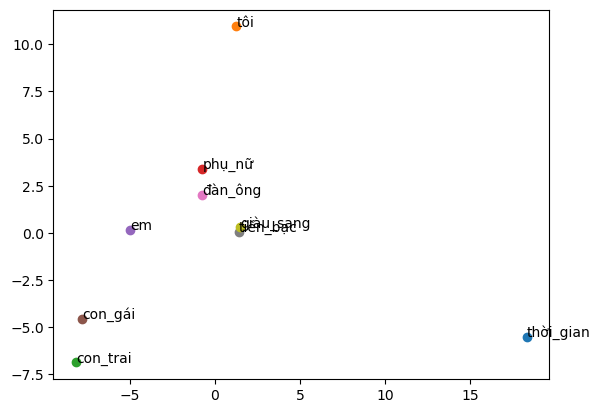

In [64]:
model = word2vec.KeyedVectors.load('word2vec_skipgram.model')

pathfile = 'words.txt'
with open(pathfile, 'r', encoding='utf-8') as f:
    words = f.readlines()
    words = [word.strip() for word in words]

words_np = []
words_label = []

for word in model.key_to_index.keys():
    if word in words:
        words_np.append(model[word])
        words_label.append(word)

pca = PCA(n_components=2)
pca.fit(words_np)
reduced = pca.transform(words_np)


def visualize():
    fig, ax = plt.subplots()

    for index, vec in enumerate(reduced):
        x, y = vec[0], vec[1]

        ax.scatter(x, y)
        ax.annotate(words_label[index], xy=(x, y))

    plt.show()
    return

visualize()

## Fasttext training

In [65]:
from gensim.models.fasttext import FastText

In [67]:
#load model
model_fasttext = FastText(vector_size=150, window=10, min_count=2, workers=4, sg=1)

In [68]:
# Build vocabulary
model_fasttext.build_vocab(train_data)

In [69]:
# Train the model
model_fasttext.train(train_data, total_examples=len(train_data), epochs=10)

(41487416, 51541390)

In [70]:
# Lưu mô hình
model_fasttext.save("fasttext_skipgram.model")

In [71]:
# Kiểm tra từ điển của mô hình
vocabulary = list(model_fasttext.wv.key_to_index.keys())
print(f"Number of words in the vocabulary: {len(vocabulary)}")
print("First 10 words in the vocabulary:")
print(vocabulary[:10])

Number of words in the vocabulary: 79968
First 10 words in the vocabulary:
['là', 'và', 'một', 'trong', 'được', 'của', 'năm', 'loài', 'các', 'có']


# 2.Finish script for pipeline in slide 28

In [72]:
Punc2Remove = string.punctuation + string.digits + "\n"

def clean_text(text):
    translation_table = str.maketrans('', '', Punc2Remove)
    text = text.translate(translation_table)
    text = text.lower()
    return text

with open('truyen_kieu_data.txt', 'r', encoding='utf-8') as file:
    data = file.readlines()

cleaned_data = [clean_text(line) for line in data]

In [73]:
print(f"Data: {data[0]}")
exs = clean_text(data[0])
print(f"Cleaned text: {exs}")

Data: 1..Trăm năm trong cõi người ta,

Cleaned text: trăm năm trong cõi người ta


In [74]:
cleaned_data = []
for line in data:
    line = clean_text(line)
    cleaned_data.append(line)

cleaned_data[:10]

['trăm năm trong cõi người ta',
 'chữ tài chữ mệnh khéo là ghét nhau',
 'trải qua một cuộc bể dâu',
 'những điều trông thấy mà đau đớn lòng',
 ' lạ gì bỉ sắc tư phong',
 'trời xanh quen thói má hồng đánh ghen',
 'cảo thơm lần giở trước đèn',
 'phong tình có lục còn truyền sử xanh',
 'rằng năm gia tĩnh triều minh',
 ' bốn phương phẳng lặng hai kinh vững vàng']

In [75]:
def get_centers_and_contexts(corpus, max_window_size=2):
    centers = []
    contexts = []

    for line in corpus:
        line = line.split()

        if len(line) <= 2 * max_window_size:
            continue

        for i in range(max_window_size, len(line) - max_window_size):
            centers.append(line[i])
            idxs = list(range(i - max_window_size, i + max_window_size + 1))
            idxs.remove(i)
            contexts.append([line[idx] for idx in idxs])

    return centers, contexts

In [76]:
centers, contexts = get_centers_and_contexts(cleaned_data)
len(centers)

9778

In [77]:
# make dataset 
class TextDataset(Dataset):
    def __init__(self, contexts, centers, word2idx, max_length):
        self.contexts = contexts
        self.centers = centers
        self.word2idx = word2idx
        self.max_length = max_length

    def __len__(self):
        return len(self.centers)

    def __getitem__(self, idx):
        context_indices = [self.word2idx.get(word, self.word2idx['<OOV>']) for word in self.contexts[idx]]
        center_index = self.word2idx.get(self.centers[idx], self.word2idx['<OOV>'])
        context_indices = context_indices + [0] * (self.max_length - len(context_indices))
        return torch.tensor(context_indices, dtype=torch.long), torch.tensor(center_index, dtype=torch.long)

In [79]:
# Make dictionary
word_counter = Counter([word for context in contexts for word in context] + centers)
word2idx = {word: idx for idx, (word, _) in enumerate(word_counter.items(), start=1)}
word2idx['<OOV>'] = 0
vocab_size = len(word2idx)
max_length = 4

In [80]:
# Build dataset and dataloader
dataset = TextDataset(contexts, centers, word2idx, max_length)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [81]:
# Build CBOW model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = embeds.mean(dim=1)
        out = self.linear(embeds)
        return out

In [84]:
# Set up parameter to train CBOW
embedding_size = 250
model = CBOW(vocab_size, embedding_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Admin\miniconda3\envs\son\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
# Training the model
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for contexts, centers in progress_bar:
        optimizer.zero_grad()
        outputs = model(contexts)
        loss = criterion(outputs, centers)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(progress_bar))
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

Epoch 1, Loss: 7.340356011016696


Epoch 2, Loss: 5.836013476053874


Epoch 3, Loss: 4.715860160737256


Epoch 4, Loss: 3.72661389478671


Epoch 5, Loss: 2.8801872212123247


Epoch 6, Loss: 2.2232956785002567


Epoch 7, Loss: 1.7509055147373598


Epoch 8, Loss: 1.3981396268590602


Epoch 9, Loss: 1.1321154835274796


Epoch 10, Loss: 0.9246506712892476


In [87]:
# Predict the word
sample_text = 'trăm năm cõi người ta'
sample_words = clean_text(sample_text).split()
sample_indices = [word2idx.get(word, word2idx['<OOV>']) for word in sample_words]
sample_indices = sample_indices + [0] * (max_length - len(sample_indices))
sample_tensor = torch.tensor([sample_indices], dtype=torch.long)
model.eval()
with torch.no_grad():
    output = model(sample_tensor)
predicted_word_idx = output.argmax(dim=1).item()
predicted_word = list(word2idx.keys())[list(word2idx.values()).index(predicted_word_idx)]

print(f"Predicted word: {predicted_word}")

Predicted word: cũng
